In [1]:
import pandas as pd

In [2]:
!pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U

     |████████████████████████████████| 109.7 MB 8.6 kB/s 
     |████████████████████████████████| 100 kB 11.6 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
from sklift.metrics import qini_auc_score
from sklift.metrics import uplift_by_percentile
from sklift.metrics import weighted_average_uplift
from sklift.metrics import uplift_at_k

In [4]:
from sklift.models import TwoModels
from sklift.models import SoloModel
from sklift.models import ClassTransformation

In [5]:
import numpy as np

In [6]:
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_preds

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
from sklearn.pipeline import Pipeline

In [13]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 22 kB/s 


In [15]:
from catboost import CatBoostClassifier

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
from sklearn.utils.validation import check_consistent_length

In [18]:
import matplotlib.pyplot as plt

In [19]:
# замена для родной функции из skuplift
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

## Домашнее задание 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Задание 1

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [24]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [25]:
path = '/gdrive/MyDrive/Colab_Notebooks/Geekbrains_ML_analysis/ML_in_business_Hw_04/'
#path=''

In [26]:
df = pd.read_csv(path + 'data.csv')

In [27]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [28]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


Проверка на NaN

In [29]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

### Задание 2

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [30]:
df = df.rename(columns={'conversion':'target', 'offer':'treatment'})

In [31]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

Производим замену полей на числовые признаки и преобразуем тип числовых признаков в int

In [32]:
df['treatment'].loc[df['treatment'] != 'No Offer'] = 1
df['treatment'].loc[df['treatment'] == 'No Offer'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [33]:
df['treatment'] = df['treatment'].astype('int')

In [34]:
df['treatment'].unique()

array([1, 0])

--------------------------------------------------------

### Задание 3, 4

3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Т.к. имеет смысл сначала обработать датасет, а затем уже разбивать его на подвыборки задания 3 и 4 будут выполняться в обратнеом порядке.

In [35]:
y = df[['target']]

In [36]:
treatment = df[['treatment']]

In [37]:
X = df.drop(['treatment', 'target'], axis = 1)

In [38]:
y.head()

,target
0,0
1,0
2,0
3,0
4,0


In [39]:
X.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web


In [40]:
treatment.head()

,treatment
0,1
1,0
2,1
3,1
4,1


Проведем анализ оставшихся полей.

In [41]:
X['recency'].nunique()

12

In [42]:
X['used_discount'].nunique()

2

In [43]:
X['used_bogo'].nunique()

2

In [44]:
X['zip_code'].nunique()

3

In [45]:
X['is_referral'].nunique()

2

In [46]:
X['channel'].nunique()

3

заменим is_referral и channel на цифровые признаки для более удобного послеующего взаимодействия.  
Признаки будут ранжироваться по частоте.

In [47]:
X['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [48]:
X['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [49]:
X['channel'].loc[X['channel'] == 'Web'] = 2
X['channel'].loc[X['channel'] == 'Phone'] = 1
X['channel'].loc[X['channel'] == 'Multichannel'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [50]:
X['channel'].value_counts()

2    28217
1    28021
0     7762
Name: channel, dtype: int64

In [51]:
X['zip_code'].loc[X['zip_code'] == 'Surburban'] = 2
X['zip_code'].loc[X['zip_code'] == 'Urban'] = 1
X['zip_code'].loc[X['zip_code'] == 'Rural'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [52]:
X['zip_code'].value_counts()

2    28776
1    25661
0     9563
Name: zip_code, dtype: int64

В качестве критериев можно было использовать более сложный способ, но так как CatBoost умеет работать с категориальными переменными имеет смысл оставить только замену на цифры без вычисления более сложных зависимостей..

In [53]:
X['zip_code'] = X['zip_code'].astype('int')

In [54]:
X['channel'] = X['channel'].astype('int')

In [55]:
X.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,2,0,1
1,6,329.08,1,1,0,1,2
2,7,180.65,0,1,2,1,2
3,9,675.83,1,0,0,1,2
4,2,45.34,1,0,1,0,2


Создаем список колонок с категориальными переменными

In [56]:
cat_features = ['recency', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

Выполняем разбивку датасета на выборки

In [57]:
# X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, 
#                                                                                     y, 
#                                                                                     treatment, 
#                                                                                     test_size=0.3, 
#                                                                                     random_state=35)

In [93]:
# X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, 
#                                                                                    y, 
#                                                                                    treatment, 
#                                                                                    test_size=0.2, 
#                                                                                    random_state=35)

In [108]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, 
                                                                                   y, 
                                                                                   treatment, 
                                                                                   test_size=0.1, 
                                                                                   random_state=35)

In [58]:
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@30%': []    
}

In [59]:
models_results['uplift@20%']=[]


In [60]:
models_results['uplift@10%']=[]

----------------------------------------------------------------------------------------------

### Задание 5

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

#### Single model

Объявление классификатора

In [61]:
sm = SoloModel(
    CatBoostClassifier(
        iterations=20, 
        thread_count=2, 
        random_state=42, 
        silent=True))

Тренировка модели

In [109]:
%%time
sm = sm.fit(
    X_train, 
    y_train, 
    treat_train, 
    estimator_fit_params={'cat_features': cat_features})

CPU times: user 785 ms, sys: 40.3 ms, total: 825 ms
Wall time: 503 ms


Получение предсказаний

In [110]:
uplift_sm = sm.predict(X_test)

Получение оценки

In [111]:
sm_score = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

In [65]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [97]:
# models_results['approach'].append('SoloModel')
# models_results['uplift@20%'].append(sm_score)

In [112]:
# models_results['approach'].append('SoloModel')
# models_results['uplift@10%'].append(sm_score)

In [66]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_

In [67]:
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

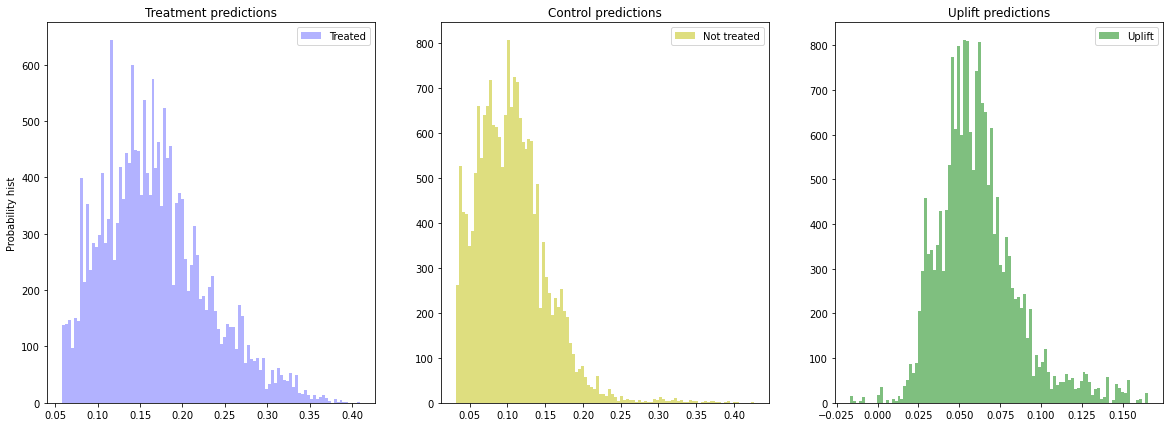

In [68]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(sm_trmnt_preds , sm_ctrl_preds, bins=100);

Построим дополнительные графики для оценки uplift

/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


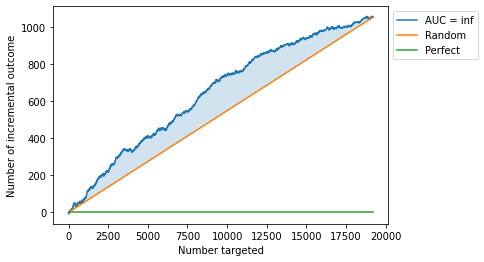

In [69]:
# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_sm, treat_test); # perfect=True

/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:373: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


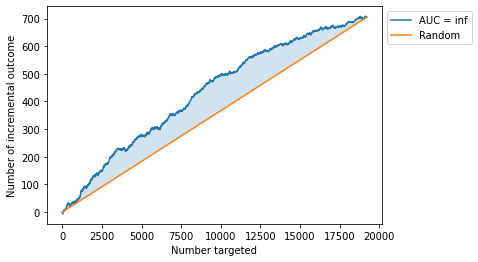

In [70]:
# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_sm, treat_test, perfect=False);

In [71]:
# коэффициент qini, или area under qini curve (AUQC)
auqc = qini_auc_score(y_test, uplift_sm, treat_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: inf


/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:373: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


In [72]:
# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_test, 
                     uplift_sm, 
                     treat_test, 
                     strategy='overall', 
                     total=True, 
                     std=True, 
                     bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1286,634,0.282271,0.184543,0.097728,0.012551,0.015407,0.019872
10-20,1308,612,0.217125,0.137255,0.079870,0.011400,0.013910,0.017985
20-30,1292,628,0.191176,0.136943,0.054234,0.010940,0.013719,0.017547
30-40,1259,661,0.177919,0.119516,0.058403,0.010778,0.012617,0.016594
40-50,1246,674,0.181380,0.097923,0.083458,0.010916,0.011448,0.015819
50-60,1284,636,0.150312,0.105346,0.044966,0.009973,0.012173,0.015737
60-70,1308,612,0.141437,0.094771,0.046666,0.009635,0.011840,0.015265
70-80,1290,630,0.113953,0.085714,0.028239,0.008847,0.011153,0.014236
80-90,1293,627,0.109822,0.084530,0.025293,0.008695,0.011109,0.014108


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


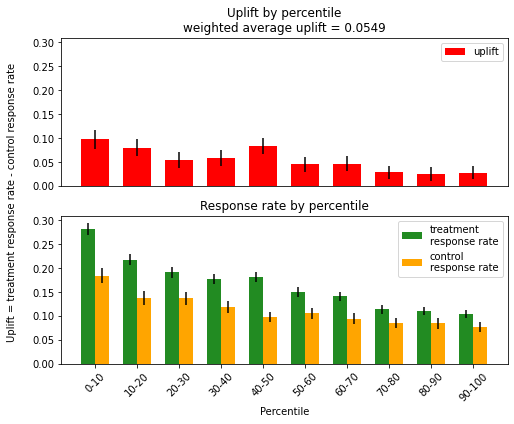

In [73]:
# график uplift by percentile
plot_uplift_by_percentile(y_test, 
                          uplift_sm, 
                          treat_test, 
                          strategy='overall', 
                          kind='bar');

In [74]:
# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, 
                                           uplift_sm, 
                                           treat_test, 
                                           bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0546


In [75]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,18.831625
1,is_referral,16.938224
2,recency,16.871325
3,zip_code,11.389585
4,used_bogo,10.929571
5,channel,10.807956
6,used_discount,8.561885
7,history,5.669829


------------------------------------

#### Трансформация классов

Будем использовать тот же набор данных, что и для предыдущего случая

In [76]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=44, silent=True))

Тренировка модели

In [113]:
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

Получение предсказаний

In [114]:
uplift_ct = ct.predict(X_test)

Подсчет метрики качества

In [115]:
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

Добавление результатов модели в табличку для сравнения результатов.

In [80]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [101]:
# models_results['approach'].append('ClassTransformation')
# models_results['uplift@20%'].append(ct_score)

In [116]:
# models_results['approach'].append('ClassTransformation')
# models_results['uplift@10%'].append(ct_score)

#### Две независимые модели

Объявляем две независимые модели

In [117]:
treat_train_np = np.array(treat_train['treatment'])

In [82]:
tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
) 

Обучаем модели

In [118]:
# method ='ddr_control' ('ddr_treatment') - зависимые модели
%time
tm = tm.fit(
    X_train, 
    y_train, 
    treat_train_np,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


Получаем предсказания

In [119]:
uplift_tm = tm.predict(X_test)

Получение оценки

In [120]:
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

Присоединяем полученный результат к списку результатов

In [86]:
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

In [107]:
# models_results['approach'].append('TwoModels')
# models_results['uplift@20%'].append(tm_score)

In [121]:
# models_results['approach'].append('TwoModels')
# models_results['uplift@10%'].append(tm_score)

Получение графиков

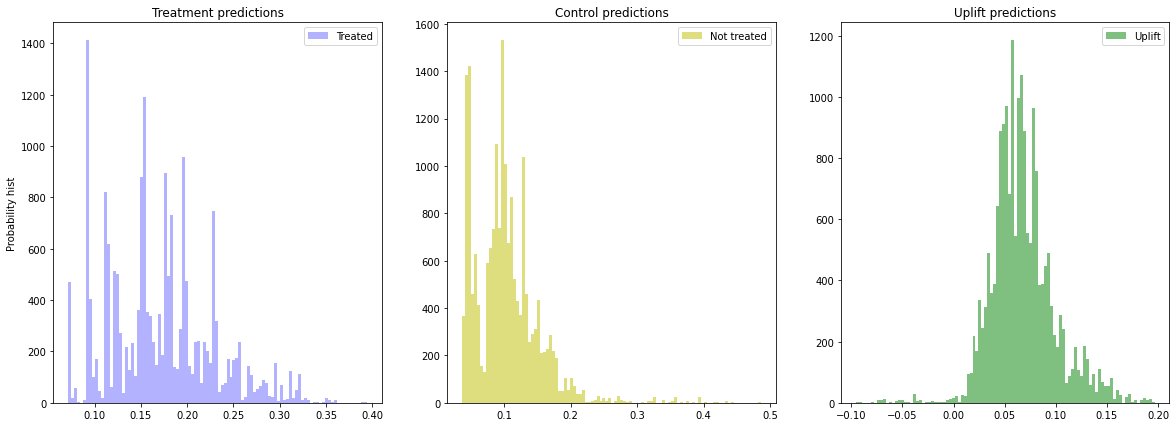

In [87]:
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Solo Model


/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


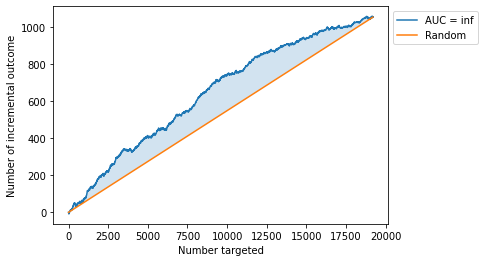

In [88]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()

ClassTransform Model


/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


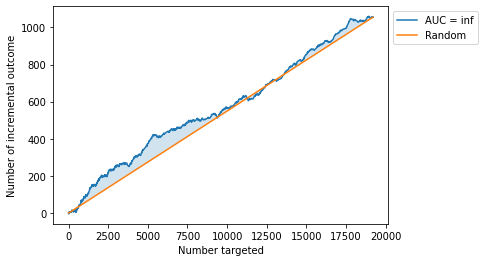

In [89]:
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()

Two Model


/usr/local/lib/python3.7/dist-packages/sklift/metrics/metrics.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  return auc_score_actual / auc_score_perfect


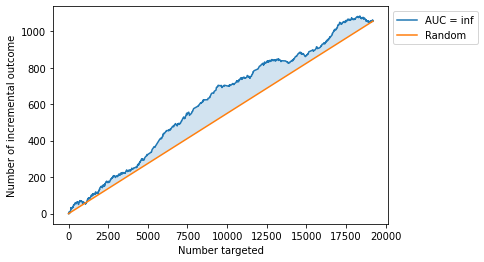

In [90]:
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

In [91]:
uplift_by_percentile(y_test,uplift_tm, treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1300,620,0.250769,0.185484,0.065285,0.012022,0.015610,0.019703
10-20,1273,647,0.187745,0.131376,0.056370,0.010945,0.013281,0.017210
20-30,1254,666,0.188198,0.100601,0.087597,0.011038,0.011656,0.016053
30-40,1270,650,0.160630,0.092308,0.068322,0.010304,0.011354,0.015332
40-50,1302,618,0.166667,0.084142,0.082524,0.010328,0.011167,0.015211
50-60,1293,627,0.162413,0.132376,0.030037,0.010257,0.013534,0.016982
60-70,1271,649,0.161290,0.117103,0.044187,0.010317,0.012622,0.016302
70-80,1259,661,0.108817,0.083207,0.025609,0.008776,0.010743,0.013872
80-90,1299,621,0.149346,0.070853,0.078492,0.009889,0.010296,0.014276


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


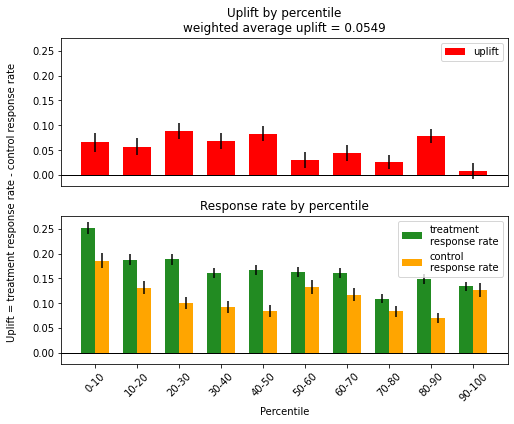

In [92]:
plot_uplift_by_percentile(y_test, uplift_tm, treat_test, 
                          strategy='overall', kind='bar'); # line

--------------------

### Задание 6

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

Избавляемся от дубликатов в словаре.

In [122]:
models_results['approach'] = list(set(models_results['approach']))

In [123]:
models_results

{'approach': ['ClassTransformation', 'SoloModel', 'TwoModels'],
 'uplift@10%': [0.11386688184663538, 0.10917449139280125, 0.09591280320813772],
 'uplift@20%': [0.09200027026113983, 0.08173710347623392, 0.07480152697544001],
 'uplift@30%': [0.07810642537302881, 0.07183965552683011, 0.07065563776805922]}

Выводим табличку с результатами.

In [124]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
0,ClassTransformation,0.078106,0.092000,0.113867
1,SoloModel,0.071840,0.081737,0.109174
2,TwoModels,0.070656,0.074802,0.095913


----------------------------

### Задание 7

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [232]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, 
                                                                                    y, 
                                                                                    treatment, 
                                                                                    test_size=0.3, 
                                                                                    random_state=35)

Попробуем использлвать модель представленную на занятии.  
Т.к. требуемые преобразования были выполнены на этапе предобработки, то считаем что дополнительная местная предобработка не требуется.

In [126]:
#!pip install causalml


     |████████████████████████████████| 243 kB 7.7 MB/s 
     |████████████████████████████████| 326 kB 43.2 MB/s 
     |████████████████████████████████| 1.8 MB 40.5 MB/s 
     |████████████████████████████████| 678 kB 47.2 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496063 sha256=3566af99c5bdb6ca19870c15baa4492d21ec52f4f07517334df4ba33105fa2fe
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465073 sha256=911ace86b3075dc939606d7ec6fc472f74483778bbc052f3a28cf4f77063a742
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [127]:
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [233]:
%%time
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 17.6 µs


In [234]:
y_train.head()

,target
15121,0
44744,0
27233,0
3790,0
1324,0


Обучение модели

In [235]:
treat_train_np = pd.Series(treat_train['treatment'])

In [236]:
uplift_model.fit(X_train.values,
                 treatment=treat_train_np.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train['target'])

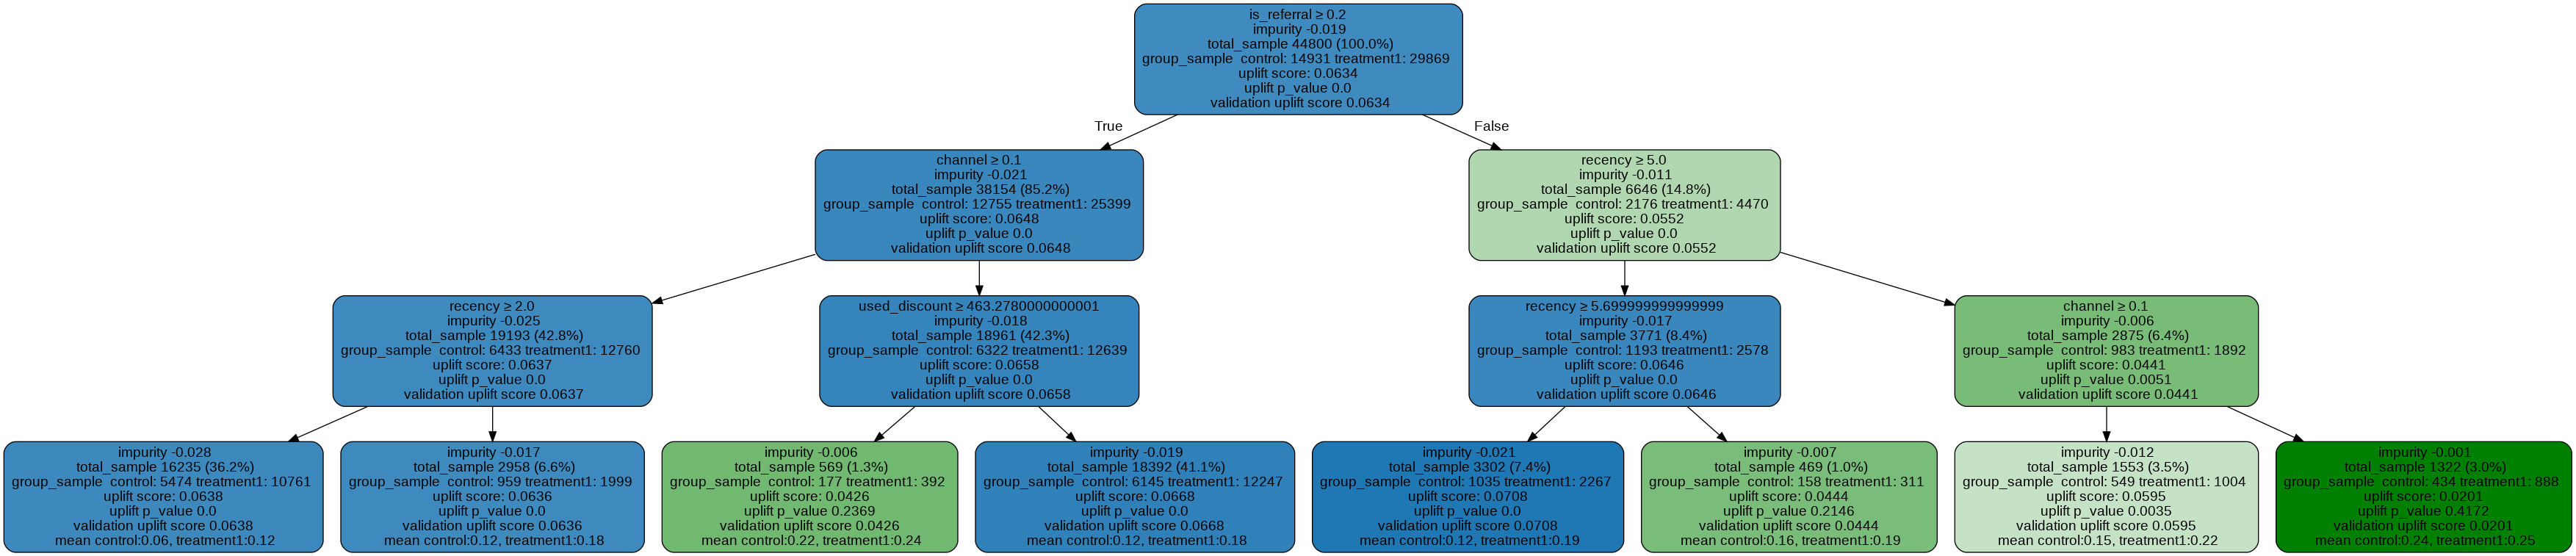

In [237]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, cat_features)
display(Image(graph.create_png()))

Получение предсказаний на тестовой выборке

In [238]:
y_pred_tree = uplift_model.predict(X_test.values)

In [239]:
tree_lift =  y_pred_tree[1]

In [240]:
uplift_tree_30 = uplift_at_k(y_test, tree_lift, treat_test,  strategy='by_group')
print(f'uplift@30%: {uplift_tree_30:.4f}')


uplift@30%: 0.0485


In [241]:
models_results['approach'].append('TreeModel')
models_results['uplift@30%'].append(uplift_tree_30)

In [225]:
# models_results['approach'].append('TreeModels')
# models_results['uplift@20%'].append(uplift_tree_30)

In [209]:
# models_results['approach'].append('TreeModels')
# models_results['uplift@10%'].append(uplift_tree_30)

Выведение графика

Tree Model


divide by zero encountered in double_scalars


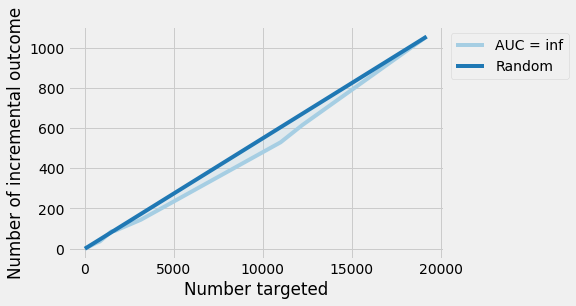

In [242]:
print('Tree Model')
plot_uplift_curve(y_test, tree_lift, treat_test, perfect=False)
plt.show()

### Задание 8

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

### Задание 9

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

Подготовка модели Random Forest   
Гиперпараметры взяты из урока ввиду некоторых огранчений по вычислительной мощности.

In [155]:
# Train uplift RandomForest
uplift_model_RF = UpliftRandomForestClassifier(n_estimators=5, 
                                               max_depth = 5, 
                                               min_samples_leaf = 200, 
                                               min_samples_treatment = 50, 
                                               n_reg = 100, 
                                               evaluationFunction='KL', 
                                               control_name='control')


Шаг, в сущности, бесполезный, и даже вредный, но без него модель постоянно выдавала ошибку.

In [243]:
X_test_rf = X_test.reset_index()
y_test_rf = y_test.reset_index()
X_train_rf = X_test.reset_index()
y_train_rf = y_test.reset_index()

Обучение модели

In [244]:
uplift_model_RF.fit(X_train_rf.values,
                 treatment=treat_train_np.map({1: 'aaa', 0: 'control'}).values,
                 y=y_train_rf['target'])

Получение предсказаний

In [245]:
y_pred_RF = uplift_model_RF.predict(X_test_rf.values)

In [246]:
tree_lift_RF =  y_pred_RF[:,0]

Получение результатов и добавление их в сводную таблицу по результатам.

In [247]:
uplift_treeRF_30 = uplift_at_k(y_test, tree_lift_RF, treat_test,  strategy='by_group')
print(f'uplift@30%: {uplift_treeRF_30:.4f}')

uplift@30%: 0.0626


In [248]:
models_results['approach'].append('ForestModels')
models_results['uplift@30%'].append(uplift_treeRF_30)

In [231]:
# models_results['approach'].append('ForestModels')
# models_results['uplift@20%'].append(uplift_treeRF_30)

In [215]:
# models_results['approach'].append('ForestModels')
# models_results['uplift@10%'].append(uplift_treeRF_30)

Вывод на печать одного из деревьев.

In [249]:

# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model_RF.uplift_forest[1]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, X_train.columns)

is_referraltreatment_group_key >= 0.2?
yes -> channeltreatment_group_key >= 0.1?
		yes -> used_discounttreatment_group_key >= 752.23?
				yes -> historytreatment_group_key >= 4.0?
						yes -> {'control': 0.168421, 'aaa': 0.169811}
						no  -> {'control': 0.128049, 'aaa': 0.199005}
				no  -> recencytreatment_group_key >= 19362.1?
						yes -> {'control': 0.109923, 'aaa': 0.099309}
						no  -> {'control': 0.103591, 'aaa': 0.118359}
		no  -> recencytreatment_group_key >= 6442.800000000001?
				yes -> recencytreatment_group_key >= 34677.0?
						yes -> {'control': 0.205263, 'aaa': 0.157245}
						no  -> {'control': 0.17121, 'aaa': 0.168485}
				no  -> recencytreatment_group_key >= 4537.0?
						yes -> {'control': 0.126761, 'aaa': 0.132184}
						no  -> {'control': 0.302469, 'aaa': 0.118519}
no  -> historytreatment_group_key >= 11.0?
		yes -> {'control': 0.25, 'aaa': 0.067901}
		no  -> used_discounttreatment_group_key >= 404.97800000000007?
				yes -> recencytreatment_group_key >= 27360

Визуализация дерева.

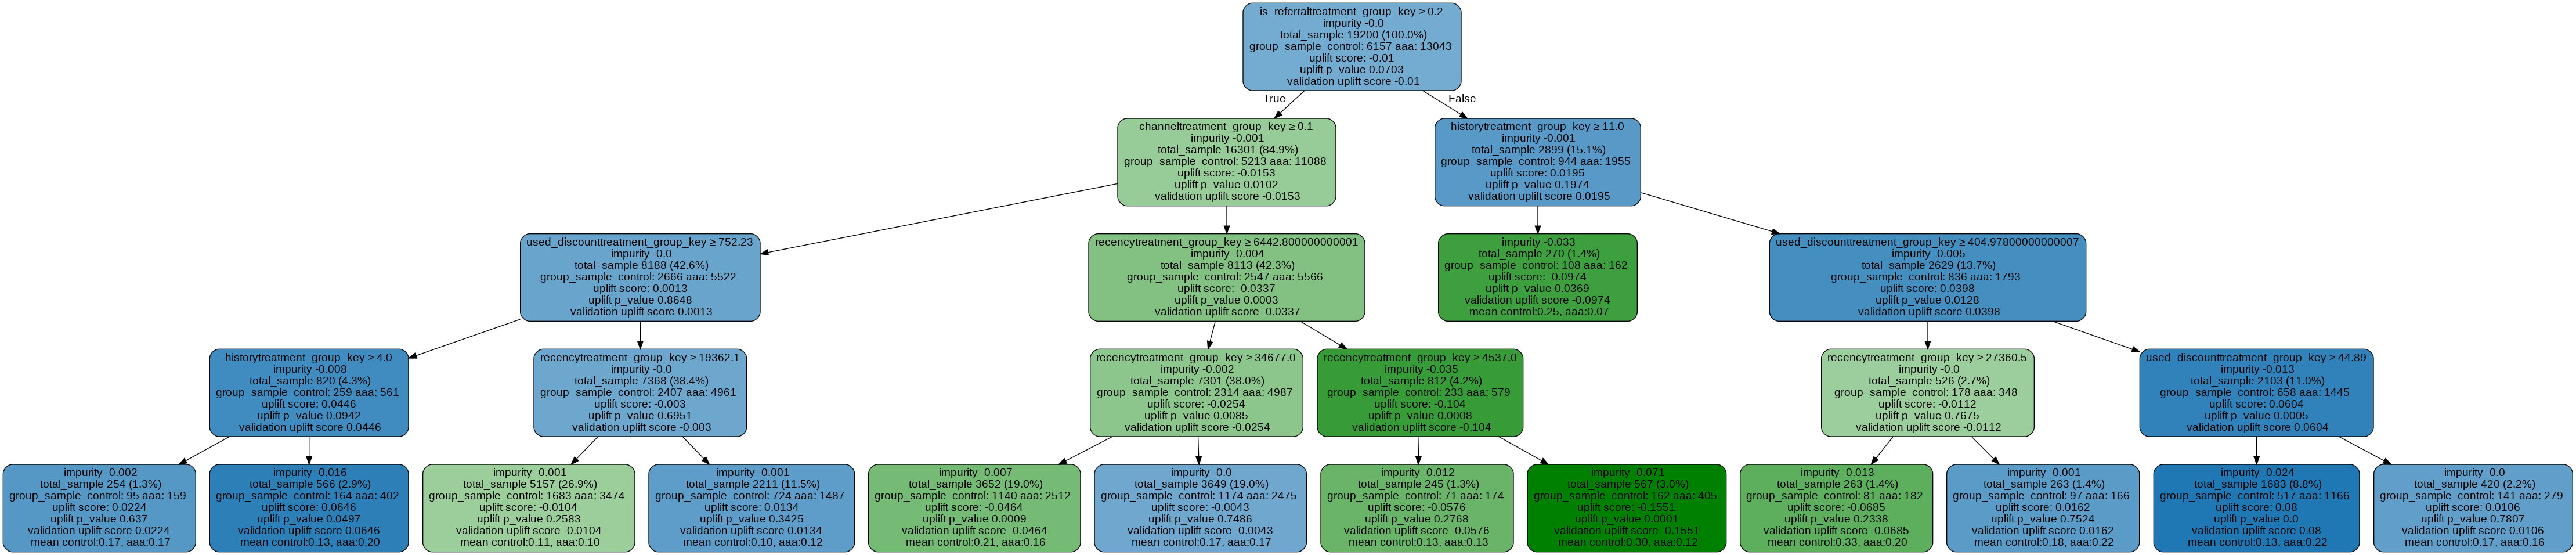

In [250]:

# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,X_train.columns)
display(Image(graph.create_png()))